# Install Deps

In [510]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters beautifulsoup4

# Set API Key

In [511]:
import getpass
import os

def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")

_set_env("OPENAI_API_KEY")

# Index 3 Blog Articles

In [512]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

# Create Retriever

In [513]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng's blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs. Keep all query parameters as simple as possible.",
)

tools = [retriever_tool]

# Configure Agent State

In [514]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Configure Nodes & Edges

In [515]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage, RemoveMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
# from langchain_core.pydantic_v1 import BaseModel, Field
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---GRADING DOCUMENTS---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader that assesses the relevance of retrieved documentation to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        Only if the retrieved document contains information to answer the user question or contains words similar to that in the user question, grade it as relevant. \n
        Think twice before issuing final grade or score. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the user question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite"


### Nodes

def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---AGENT---")
    messages = state["messages"]
    print("---AGENT STATE---")
    print(messages)
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    print("---Agent Response---")
    print(response)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---REWRITE---")
    messages = state["messages"]
    print("---Messages---")
    print(messages)
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    humanResponse = HumanMessage(content=response.content)
    return {"messages": humanResponse}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    print("--- MESSAGE STATE ---")
    messages = state["messages"]
    print(messages)
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

def delete_messages(state):
    messages = state["messages"]
    print("---DELETE MESSAGES---")
    print(messages)
    return {"messages": [RemoveMessage(id=m.id) for m in messages[:-1]]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************


c:\Users\juanhart\Code\ai-gbb-learning-shop\.conda\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


# Construct Graph

In [516]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool]) # retrieval tool node
workflow.add_node("retrieve", retrieve)  # retrieval no
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node("generate", generate)  # Generating a response after we know the documents are relevant
workflow.add_node("delete_messages", delete_messages)  # Delete messages
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("rewrite", "delete_messages")
workflow.add_edge("delete_messages", "agent")
workflow.add_edge("generate", END)

# Compile
graph = workflow.compile()

# Create Visual of Graph

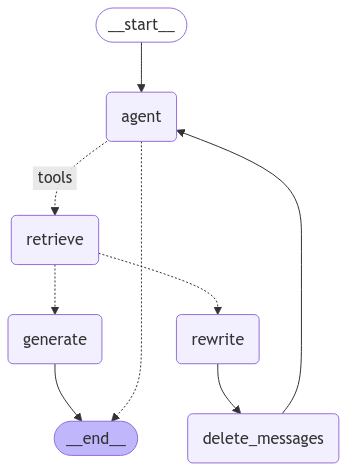

In [517]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Invoke Agent/Graph with Prompt

In [524]:
import pprint

inputs = {
    "messages": [
        # ("user", "What are the different types of memory for agents outlined by Lilian Weng?"), #happy path
        # ("user", "What does Lilian Weng think about prompt engineering?"), #kind of happy path
        # ("user", "When it comes to prompt engineering, what does Lilian Weng think?"), #happy path
        ("user", "What are some prompt engineering strategies outlined by Lilian Weng?"), #unhappy path
        # ("user", "What does Lilian Weng think about the price of tea in China?"), #unhappy path
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=40, depth=None)
    pprint.pprint("\n---\n")

---AGENT---
---AGENT STATE---
[HumanMessage(content='What are some prompt engineering strategies outlined by Lilian Weng?', additional_kwargs={}, response_metadata={}, id='7f8dd458-0d8d-43b6-abec-2a5697eb6dd4')]
---Agent Response---
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_POafA5zEUFuOD0bfNWXVW2Nl', 'function': {'arguments': '{"query":"prompt engineering strategies"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87'} id='run-c5c05fbf-d3eb-4acd-a199-cbf4686b5133-0' tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'prompt engineering strategies'}, 'id': 'call_POafA5zEUFuOD0bfNWXVW2Nl', 'type': 'tool_call'}]
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_POafA5zEUFuOD0bfNWXVW2Nl', 'function': {'arguments': '{"query":"prompt engineering st

c:\Users\juanhart\Code\ai-gbb-learning-shop\.conda\Lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{'messages': ["I don't know."]}
'\n---\n'
